In [2]:
# importing required libraries

import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import utils
import train_val_scripts
from pathlib import Path
from torchvision import transforms, models, datasets

%matplotlib inline

In [3]:
# Simple data augmentation for training set
train_tfms = transforms.Compose([
              transforms.Resize((500,500)),
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomVerticalFlip(p=0.5),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# No data augmentation for validation set, only normalizing data
valid_tfms = transforms.Compose([
              transforms.Resize((500,500)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = '../summer_winter_dataset/'

In [5]:
train_ds = datasets.ImageFolder(data_dir+'train', transform=train_tfms)
valid_ds = datasets.ImageFolder(data_dir+'val', transform=valid_tfms)

In [6]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
x,y = next(iter(valid_dl))

In [8]:
classes = train_ds.classes; classes

['summer', 'winter']

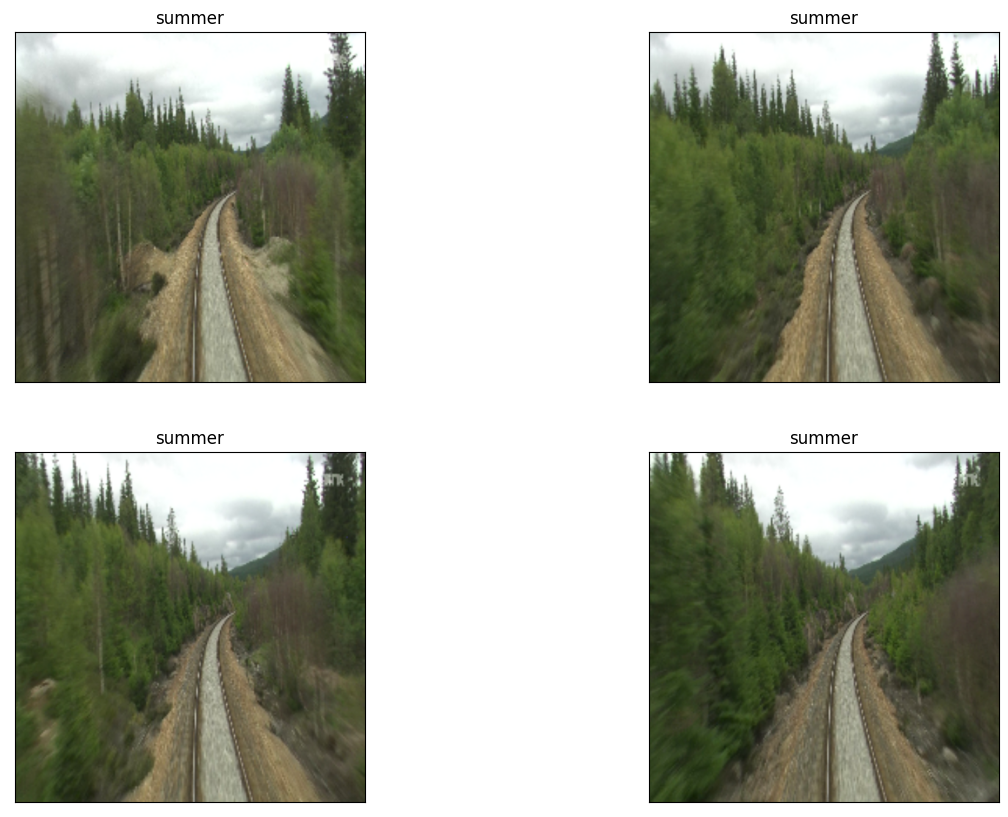

In [9]:
# visualizing sample images
utils.show_batch(x, [classes[i] for i in y], nimgs=4)

In [10]:
# loading imagenet pretrained mobilenet v2 from torchvision models
mbv2 = models.mobilenet_v2(pretrained=True)

###  Converting to ONNX

In [11]:
# import torch.onnx
# print(x.shape)
# torch.onnx.export(mbv2,
#                   x,
#                   f = './ex.onnx',
#                   export_params=True,
#                   example_outputs=y[0])

In [12]:
in_features = mbv2.classifier[1].in_features; in_features

1280

In [13]:
# replace final FC layer of model with FC layer with number of output classes = 2 for day/night
mbv2.classifier[1] = nn.Linear(in_features, 2)

In [14]:
# moving model to GPU for training
# mbv2 = mbv2.to(device='cuda:0')

In [15]:
# Using Softmax CrossEntropy Loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with lr=1e-4
opt = torch.optim.Adam(mbv2.parameters(), lr=1e-4)

# Cosine Annealing Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*15, eta_min=1e-6)

In [16]:
max_acc = 0.0 # Track maximum validation accuracy achieved
for epoch in range(15):
  best = False # Flag to detect best model

  # Training phase
  train_loss, train_acc = train_val_scripts.train_epoch(mbv2, train_dl, criterion, opt, scheduler)

  # Validation phase
  valid_loss, valid_acc = train_val_scripts.valid_epoch(mbv2, valid_dl, criterion)


  if valid_acc > max_acc: # Saving best model
    max_acc = valid_acc
    torch.save(mbv2.state_dict(), 'mbv2_ws.pth')
    best = True

  print('-'*25 + f'Epoch {epoch+1}' + '-'*25)
  print(f'Train Loss:{train_loss} Train Accuracy:{train_acc}')
  print(f'Valid Loss:{valid_loss} Valid Accuracy:{valid_acc}')
  if best:
    print(f'Found better model!')
  print('-'*58)

changed
-------------------------Epoch 1-------------------------
Train Loss:0.040909135261216485 Train Accuracy:0.9926086664199829
Valid Loss:1.4885721163920913 Valid Accuracy:0.5721649527549744
Found better model!
----------------------------------------------------------
changed
-------------------------Epoch 2-------------------------
Train Loss:0.0010831072848573652 Train Accuracy:1.0
Valid Loss:1.9229369928227331 Valid Accuracy:0.5635738968849182
----------------------------------------------------------
changed
-------------------------Epoch 3-------------------------
Train Loss:0.00331721647095907 Train Accuracy:0.9991304278373718
Valid Loss:1.2298529556387419 Valid Accuracy:0.6254295706748962
Found better model!
----------------------------------------------------------
changed
-------------------------Epoch 4-------------------------
Train Loss:0.0005316747128001778 Train Accuracy:1.0
Valid Loss:1.89947619420087 Valid Accuracy:0.5824742317199707
------------------------------

KeyboardInterrupt: 